In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack

In [4]:
dataset = pd.read_csv('Patient Survey HCAHPS California.csv', encoding= "ISO-8859-1")

dataset.head()



,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,HCAHPS Measure ID,HCAHPS Question,...,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Start Date,End Date
0,050002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,ALAMEDA,(510) 782-6200,H_COMP_1_A_P,"Patients who reported that their nurses ""Alway...",...,NaN,72,28.0,Not Applicable,397,28.0,23,28.0,10/01/2022,09/30/2023
1,050002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,ALAMEDA,(510) 782-6200,H_COMP_1_SN_P,"Patients who reported that their nurses ""Somet...",...,NaN,8,28.0,Not Applicable,397,28.0,23,28.0,10/01/2022,09/30/2023
2,050002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,ALAMEDA,(510) 782-6200,H_COMP_1_U_P,"Patients who reported that their nurses ""Usual...",...,NaN,20,28.0,Not Applicable,397,28.0,23,28.0,10/01/2022,09/30/2023
3,050002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,ALAMEDA,(510) 782-6200,H_COMP_1_LINEAR_SCORE,Nurse communication - linear mean score,...,NaN,Not Applicable,NaN,88,397,28.0,23,28.0,10/01/2022,09/30/2023
4,050002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,ALAMEDA,(510) 782-6200,H_COMP_1_STAR_RATING,Nurse communication - star rating,...,NaN,Not Applicable,NaN,Not Applicable,397,28.0,23,28.0,10/01/2022,09/30/2023


In [5]:
dataset.get('HCAHPS Question').iloc[2]



'Patients who reported that their nurses "Usually" communicated well'

In [6]:
from textblob import TextBlob

In [7]:
reviews = dataset['HCAHPS Question']

reviews

0        Patients who reported that their nurses "Alway...
1        Patients who reported that their nurses "Somet...
2        Patients who reported that their nurses "Usual...
3                  Nurse communication - linear mean score
4                        Nurse communication - star rating
                               ...                        
31522    Patients who reported YES, they would definite...
31523    Patients who reported YES, they would probably...
31524               Recommend hospital - linear mean score
31525                     Recommend hospital - star rating
31526                                  Summary star rating
Name: HCAHPS Question, Length: 31527, dtype: object

In [8]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [9]:
dataset['Sentiment Score'] = reviews.apply(get_sentiment)

In [10]:
dataset['Sentiment Score']

0        0.0000
1        0.0000
2       -0.2500
3       -0.3125
4        0.0000
          ...  
31522    0.0000
31523    0.0000
31524   -0.3125
31525    0.0000
31526    0.0000
Name: Sentiment Score, Length: 31527, dtype: float64

In [11]:
dataset[['HCAHPS Question','Sentiment Score']]

,HCAHPS Question,Sentiment Score
0,"Patients who reported that their nurses ""Alway...",0.0000
1,"Patients who reported that their nurses ""Somet...",0.0000
2,"Patients who reported that their nurses ""Usual...",-0.2500
3,Nurse communication - linear mean score,-0.3125
4,Nurse communication - star rating,0.0000
...,...,...
31522,"Patients who reported YES, they would definite...",0.0000
31523,"Patients who reported YES, they would probably...",0.0000
31524,Recommend hospital - linear mean score,-0.3125
31525,Recommend hospital - star rating,0.0000


In [14]:
# Convert 'HCAHPS Answer Percent' to numeric, handling non-numeric values if necessary
dataset['HCAHPS Answer Percent'] = pd.to_numeric(dataset['HCAHPS Answer Percent'], errors='coerce')

# Define the categorize_sentiment function
def categorize_sentiment(percent):
    if percent >= 70:
        return 'Positive'
    elif percent >= 20:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the sentiment categorization to create a new column
dataset['Sentiment'] = dataset['HCAHPS Answer Percent'].apply(categorize_sentiment)


In [29]:
# Step 3: Prepare features and target variable
X_text = dataset['HCAHPS Question']  # The text data
X_numeric = dataset[['HCAHPS Answer Percent', 'Number of Completed Surveys']]  # Numerical features
y = dataset['Sentiment']  # The target variable

X_numeric = X_numeric.fillna(0) 

In [31]:
X_train_text, X_test_text, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

In [32]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [34]:
from scipy.sparse import csr_matrix, hstack

# Ensure that X_train_numeric and X_test_numeric are numeric types
X_train_numeric = X_train_numeric.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_numeric = X_test_numeric.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert numeric data to sparse matrix format
X_train_numeric_sparse = csr_matrix(X_train_numeric.values)
X_test_numeric_sparse = csr_matrix(X_test_numeric.values)

X_train_combined = hstack((X_train_tfidf, X_train_numeric))
X_test_combined = hstack((X_test_tfidf, X_test_numeric))

In [35]:
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train length: {len(y_train)}")


X_train_combined shape: (25221, 134)
y_train length: 25221


In [36]:
# Remove rows with NaN values from both features and target
X_train_combined = X_train_combined.tocsr()  # Convert to Compressed Sparse Row format
X_train_combined = X_train_combined[~np.isnan(X_train_numeric.values).any(axis=1)]  # Remove NaN rows
y_train = y_train[~np.isnan(X_train_numeric.values).any(axis=1)]  # Remove corresponding rows in y_train

from sklearn.impute import SimpleImputer

# Define an imputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the numeric data before combining
X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
X_test_numeric_imputed = imputer.transform(X_test_numeric)

# Combine imputed numeric data with the TF-IDF text features
X_train_combined = hstack((X_train_tfidf, X_train_numeric_imputed))
X_test_combined = hstack((X_test_tfidf, X_test_numeric_imputed))


# Step 7: Train a Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter if needed
model.fit(X_train_combined, y_train)

LogisticRegression(max_iter=10000)

In [37]:
y_pred = model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3617
     Neutral       1.00      1.00      1.00      1979
    Positive       1.00      1.00      1.00       710

    accuracy                           1.00      6306
   macro avg       1.00      1.00      1.00      6306
weighted avg       1.00      1.00      1.00      6306



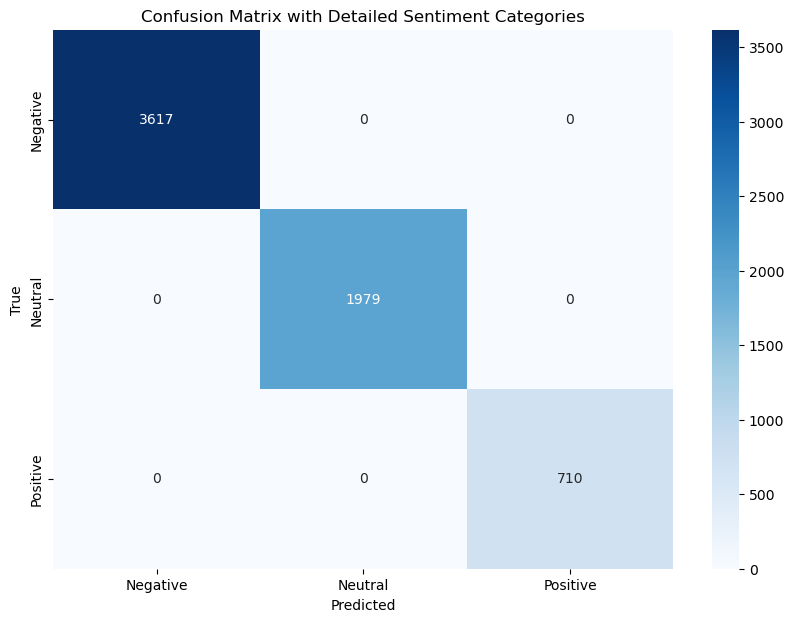

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Detailed Sentiment Categories')
plt.show()

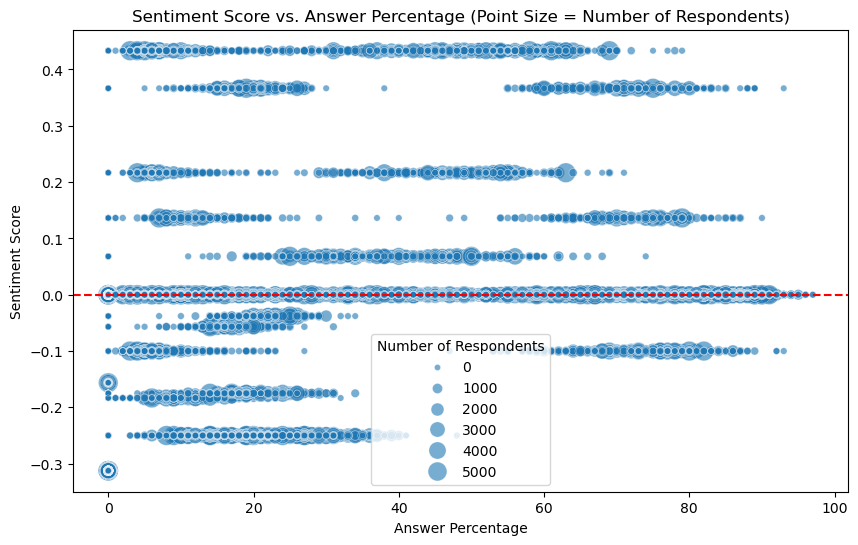

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Sentiment Score', 'HCAHPS Answer Percent', and 'Number of Respondents' to numeric
dataset['Sentiment Score'] = pd.to_numeric(dataset['Sentiment Score'], errors='coerce')
dataset['HCAHPS Answer Percent'] = pd.to_numeric(dataset['HCAHPS Answer Percent'], errors='coerce')
dataset['Number of Completed Surveys'] = pd.to_numeric(dataset['Number of Completed Surveys'], errors='coerce')

# Optionally handle NaN values (e.g., fill NaN with 0 or drop rows with NaNs)
dataset.fillna(0, inplace=True)  # You can also use dataset.dropna() to remove rows with NaNs

# Now you can create the weighted sentiment score
dataset['Weighted Sentiment Score'] = dataset['Sentiment Score'] * dataset['Number of Completed Surveys'] * (dataset['HCAHPS Answer Percent'] / 100)

plt.figure(figsize=(10, 6))

# Scatter plot with point size proportional to the number of respondents
sns.scatterplot(
    data=dataset, 
    x='HCAHPS Answer Percent', 
    y='Sentiment Score', 
    size='Number of Completed Surveys',  # Adjust the size of the points based on the number of respondents
    sizes=(20, 200),               # Minimum and maximum size of the points
    alpha=0.6                      # Slight transparency for better visibility
)

plt.title('Sentiment Score vs. Answer Percentage (Point Size = Number of Respondents)')
plt.xlabel('Answer Percentage')
plt.ylabel('Sentiment Score')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.legend(title='Number of Respondents')
plt.show()

/var/folders/sk/k57rw5s944j3wc76nd2l445w0000gn/T/ipykernel_3840/2744371050.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


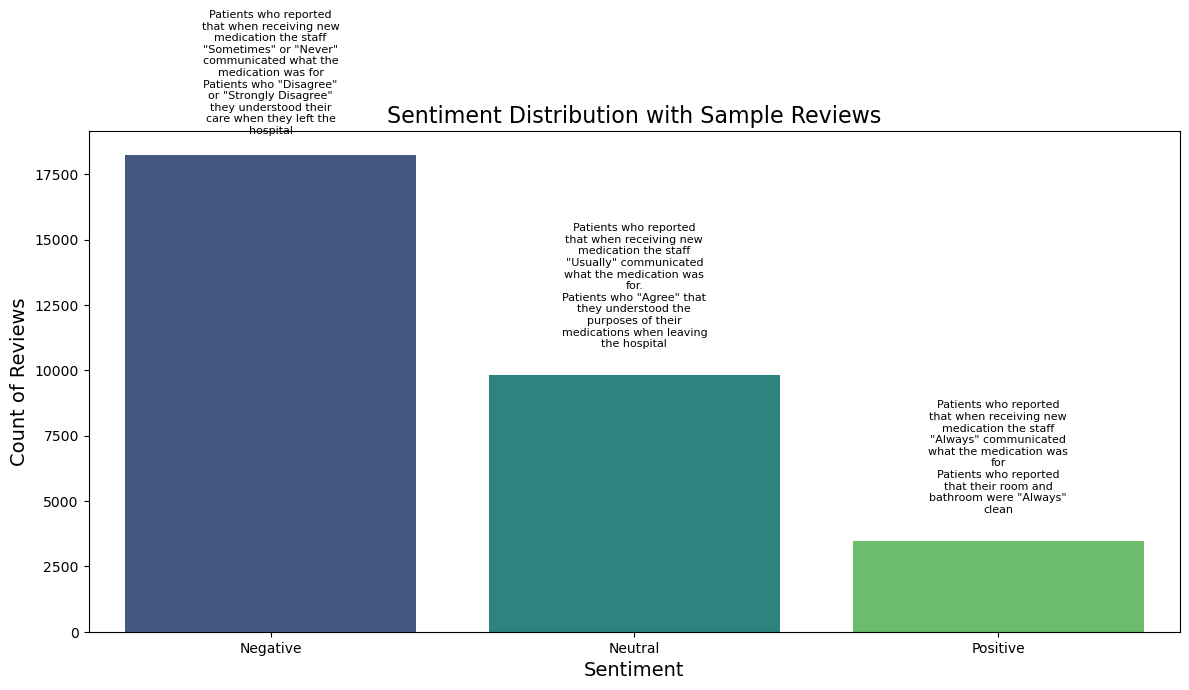

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import textwrap  # For controlling text width

# Step 1: Count the occurrences of each sentiment category
sentiment_counts = dataset['Sentiment'].value_counts()

# Step 2: Sample a few reviews from each sentiment category (limit to 2-3 reviews for clarity)
def sample_reviews(sentiment, n=3):
    reviews = dataset[dataset['Sentiment'] == sentiment]['HCAHPS Question'].values
    return random.sample(list(reviews), min(len(reviews), n))  # Get up to 'n' random samples from the reviews

# Sample 2 reviews for each sentiment for better visualization
positive_reviews = sample_reviews('Positive', n=2)
neutral_reviews = sample_reviews('Neutral', n=2)
negative_reviews = sample_reviews('Negative', n=2)

# Step 3: Create a bar chart for sentiment distribution
plt.figure(figsize=(12, 7))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Step 4: Define a function to wrap text within a specific width
def wrap_text(reviews, width=30):
    wrapped_reviews = [textwrap.fill(review, width=width) for review in reviews]  # Limit each line to 'width' characters
    return "\n".join(wrapped_reviews)

# Step 5: Add summarized review text above the bars (only a few reviews per sentiment)
def add_review_annotations(sentiment, reviews, index, count):
    reviews_text = wrap_text(reviews, width=25)  # Wrap text with a width of 25 characters
    # Adjust the vertical offset based on the sentiment
    if sentiment == 'Negative':
        y_offset = 750  # Lower the position for Negative sentiment to avoid title overlap
    else:
        y_offset = 1000  # Default position for other sentiments
    plt.text(index, count + y_offset, reviews_text, ha='center', va='bottom', fontsize=8, color='black', wrap=True)

# Step 6: Get the positions of each sentiment bar
bar_positions = {category: i for i, category in enumerate(sentiment_counts.index)}

# Annotate the bars with sample reviews
add_review_annotations('Positive', positive_reviews, bar_positions['Positive'], sentiment_counts['Positive'])
add_review_annotations('Neutral', neutral_reviews, bar_positions['Neutral'], sentiment_counts['Neutral'])
add_review_annotations('Negative', negative_reviews, bar_positions['Negative'], sentiment_counts['Negative'])

# Step 7: Add titles and labels
plt.title('Sentiment Distribution with Sample Reviews', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count of Reviews', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()